# YOLOv5

Upload and Prepare Images

In [1]:
from google.colab import files
import os, shutil

uploaded = files.upload()
os.makedirs("images", exist_ok=True)
os.makedirs("labeled_images", exist_ok=True)
os.makedirs("labels", exist_ok=True)

for filename in uploaded.keys():
    if filename.lower().endswith('.jpg'):
        shutil.move(filename, os.path.join("images", filename))

Saving OI_836_TOT_RE_SSS_OAA_4135.3.555_jsf-CH34_xtf-CH34_0_0_500_500.jpg to OI_836_TOT_RE_SSS_OAA_4135.3.555_jsf-CH34_xtf-CH34_0_0_500_500.jpg
Saving OI_836_TOT_RE_SSS_OAA_4135.3.555_jsf-CH34_xtf-CH34_0_500_500_1000.jpg to OI_836_TOT_RE_SSS_OAA_4135.3.555_jsf-CH34_xtf-CH34_0_500_500_1000.jpg
Saving OI_836_TOT_RE_SSS_OAA_4135.3.555_jsf-CH34_xtf-CH34_0_1000_500_1500.jpg to OI_836_TOT_RE_SSS_OAA_4135.3.555_jsf-CH34_xtf-CH34_0_1000_500_1500.jpg
Saving OI_836_TOT_RE_SSS_OAA_4135.3.555_jsf-CH34_xtf-CH34_0_1500_500_2000.jpg to OI_836_TOT_RE_SSS_OAA_4135.3.555_jsf-CH34_xtf-CH34_0_1500_500_2000.jpg
Saving OI_836_TOT_RE_SSS_OAA_4135.3.555_jsf-CH34_xtf-CH34_0_2000_500_2500.jpg to OI_836_TOT_RE_SSS_OAA_4135.3.555_jsf-CH34_xtf-CH34_0_2000_500_2500.jpg
Saving OI_836_TOT_RE_SSS_OAA_4135.3.555_jsf-CH34_xtf-CH34_0_2500_500_3000.jpg to OI_836_TOT_RE_SSS_OAA_4135.3.555_jsf-CH34_xtf-CH34_0_2500_500_3000.jpg
Saving OI_836_TOT_RE_SSS_OAA_4135.3.555_jsf-CH34_xtf-CH34_0_3000_500_3500.jpg to OI_836_TOT_RE_SSS

Rock Detection and YOLO Label Creation

In [2]:
import cv2

def detect_rocks_batch(uploaded_files, input_folder="images"):
    for image_name in uploaded_files.keys():
        if not image_name.lower().endswith(".jpg"):
            continue

        image_path = os.path.join(input_folder, image_name)
        img = cv2.imread(image_path)
        if img is None:
            print(f"⚠️ Couldn't load {image_path}")
            continue

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        height, width = gray.shape

        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        _, thresh = cv2.threshold(blurred, 30, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        yolo_labels = []

        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            area = cv2.contourArea(cnt)

            if area > 150:
                cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 1)
                x_center = (x + w / 2) / width
                y_center = (y + h / 2) / height
                norm_w = w / width
                norm_h = h / height
                yolo_labels.append(f"0 {x_center:.6f} {y_center:.6f} {norm_w:.6f} {norm_h:.6f}")

        out_img_path = os.path.join("labeled_images", image_name)
        cv2.imwrite(out_img_path, img)

        label_name = image_name.replace(".jpg", ".txt")
        out_txt_path = os.path.join("labels", label_name)
        with open(out_txt_path, "w") as f:
            for line in yolo_labels:
                f.write(line + "\n")

        print(f" {image_path}: {len(yolo_labels)} rocks labeled.")

detect_rocks_batch(uploaded, input_folder="images")

✅ images/OI_836_TOT_RE_SSS_OAA_4135.3.555_jsf-CH34_xtf-CH34_0_0_500_500.jpg: 1 rocks labeled.
✅ images/OI_836_TOT_RE_SSS_OAA_4135.3.555_jsf-CH34_xtf-CH34_0_500_500_1000.jpg: 1 rocks labeled.
✅ images/OI_836_TOT_RE_SSS_OAA_4135.3.555_jsf-CH34_xtf-CH34_0_1000_500_1500.jpg: 1 rocks labeled.
✅ images/OI_836_TOT_RE_SSS_OAA_4135.3.555_jsf-CH34_xtf-CH34_0_1500_500_2000.jpg: 1 rocks labeled.
✅ images/OI_836_TOT_RE_SSS_OAA_4135.3.555_jsf-CH34_xtf-CH34_0_2000_500_2500.jpg: 1 rocks labeled.
✅ images/OI_836_TOT_RE_SSS_OAA_4135.3.555_jsf-CH34_xtf-CH34_0_2500_500_3000.jpg: 1 rocks labeled.
✅ images/OI_836_TOT_RE_SSS_OAA_4135.3.555_jsf-CH34_xtf-CH34_0_3000_500_3500.jpg: 1 rocks labeled.
✅ images/OI_836_TOT_RE_SSS_OAA_4135.3.555_jsf-CH34_xtf-CH34_0_3500_500_4000.jpg: 1 rocks labeled.
✅ images/OI_836_TOT_RE_SSS_OAA_4135.3.555_jsf-CH34_xtf-CH34_0_4000_500_4500.jpg: 1 rocks labeled.
✅ images/OI_836_TOT_RE_SSS_OAA_4135.3.555_jsf-CH34_xtf-CH34_0_4500_500_5000.jpg: 1 rocks labeled.
✅ images/OI_836_TOT_RE_SS

Split Dataset into Train and Validation Sets

In [3]:
import os
import shutil
import random

base_dir = "seabed_yolo"
for split in ["train", "val", "test"]:
    os.makedirs(f"{base_dir}/images/{split}", exist_ok=True)
    os.makedirs(f"{base_dir}/labels/{split}", exist_ok=True)

images = [f for f in os.listdir("labeled_images") if f.endswith(".jpg")]
random.shuffle(images)

# 70% train, 15% val, 15% test
split_train = int(0.7 * len(images))
split_val = int(0.85 * len(images))

train_imgs = images[:split_train]
val_imgs = images[split_train:split_val]
test_imgs = images[split_val:]

def copy_split(img_list, split):
    for img in img_list:
        label = img.replace(".jpg", ".txt")
        shutil.copy(os.path.join("labeled_images", img), f"{base_dir}/images/{split}/{img}")
        label_path = os.path.join("labels", label)
        if os.path.exists(label_path):
            shutil.copy(label_path, f"{base_dir}/labels/{split}/{label}")
        else:
            print(f"⚠️ Missing label for {img}")

copy_split(train_imgs, "train")
copy_split(val_imgs, "val")
copy_split(test_imgs, "test")

print(f" Train: {len(train_imgs)} | Val: {len(val_imgs)} | Test: {len(test_imgs)}")

✅ Train: 501 | Val: 107 | Test: 108


Create YOLOv5 Data Config

In [4]:
#YOLO v5 setup
%cd /content/
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
#!pip install -r requirements.txt
!pip install -r requirements.txt --upgrade

/content
Cloning into 'yolov5'...
remote: Enumerating objects: 17581, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 17581 (delta 42), reused 12 (delta 10), pack-reused 17508 (from 3)
Receiving objects: 100% (17581/17581), 16.64 MiB | 19.75 MiB/s, done.
Resolving deltas: 100% (12036/12036), done.
/content/yolov5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 94.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 115.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.0/278.0 kB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 63.2 MB

In [5]:
"""#to upgrade to newer version
%cd /content/yolov5
!git pull
!pip install -r requirements.txt --upgrade"""

/content/yolov5
Already up to date.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 74.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 110.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.0/278.0 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 120.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 70.3 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 75.2.0
    Uninstalling setuptools-75.2.0:
      Successfully uninstalled setuptools-75.2.0
  Attempting uninstall: requests
    Found existing installation: requests 2.32.

In [1]:
data_yaml = """train: /content/seabed_yolo/images/train
val: /content/seabed_yolo/images/val
test: /content/seabed_yolo/images/test

nc: 1
names: ['rock']
"""

with open("seabed.yaml", "w") as f:
    f.write(data_yaml)

Train YOLOv5

In [2]:
!python /content/yolov5/train.py --img 501 --batch 16 --epochs 50 --data seabed.yaml --weights yolov5s.pt --project seabed_detection --name rocks_yolo

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2025-09-09 14:38:41.638251: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757428721.657939    3764 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757428721.663971    3764 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS wh

Evaluation on Validation Set YOLOv5





In [4]:
!python /content/yolov5/val.py --weights /content/seabed_detection/rocks_yolo/weights/best.pt --data seabed.yaml --img 107 --task val

val: data=seabed.yaml, weights=['/content/seabed_detection/rocks_yolo/weights/best.pt'], batch_size=32, imgsz=107, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5/runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-430-g459d8bf0 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
WARNING ⚠️ --img-size 107 must be multiple of max stride 32, updating to 128
val: Scanning /content/seabed_yolo/labels/val.cache... 107 images, 0 backgrounds, 0 corrupt: 100% 107/107 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 4/4 [00:03<00:00,  1.21it/s]
                   all        107       2228      0.765      0.486      0.551       0.31
Speed: 0.0ms pre-process, 

Testing

In [5]:
!python /content/yolov5/val.py \
  --weights /content/seabed_detection/rocks_yolo/weights/best.pt \
  --data seabed.yaml \
  --img 108 \
  --task test \
  --save-json

val: data=seabed.yaml, weights=['/content/seabed_detection/rocks_yolo/weights/best.pt'], batch_size=32, imgsz=108, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=True, project=yolov5/runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-430-g459d8bf0 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
WARNING ⚠️ --img-size 108 must be multiple of max stride 32, updating to 128
test: Scanning /content/seabed_yolo/labels/test... 108 images, 0 backgrounds, 0 corrupt: 100% 108/108 [00:00<00:00, 419.14it/s]
test: New cache created: /content/seabed_yolo/labels/test.cache
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 4/4 [00:03<00:00,  1.18it/s]
                   all        108       1724  

Visualizations

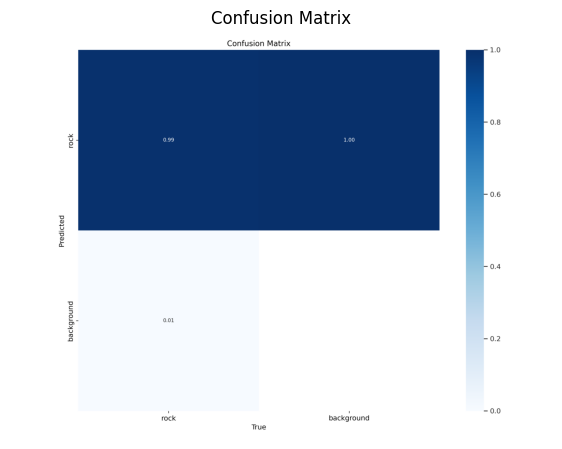

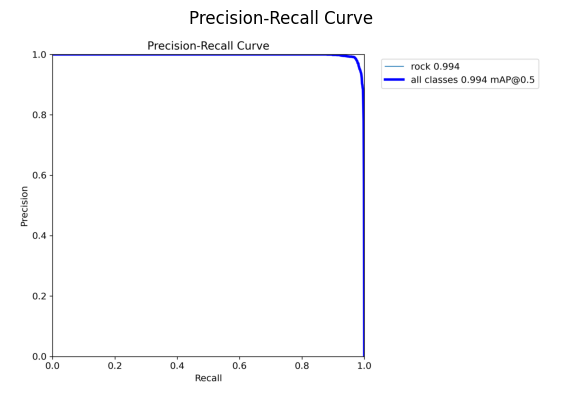

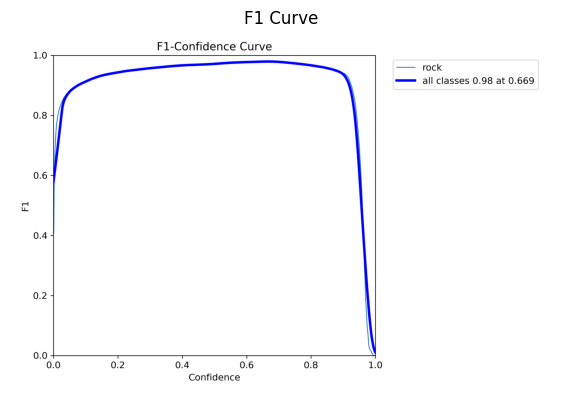

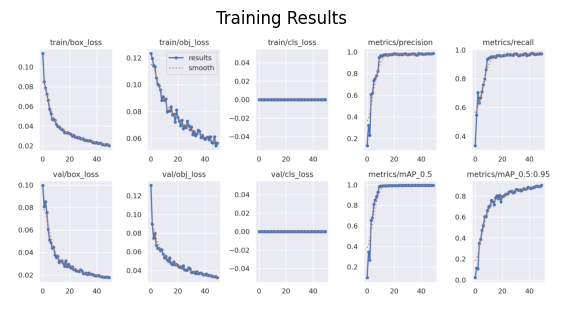

In [18]:
import matplotlib.pyplot as plt
import cv2

results_dir = "seabed_detection/rocks_yolo"

def show_img(path, title):
    if os.path.exists(path):
        img = cv2.imread(path)
        plt.figure(figsize=(7,6))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.title(title)
        plt.show()
    else:
        print(f"⚠️ {title} not found.")

show_img(os.path.join(results_dir, "confusion_matrix.png"), "Confusion Matrix")
show_img(os.path.join(results_dir, "PR_curve.png"), "Precision-Recall Curve")
show_img(os.path.join(results_dir, "F1_curve.png"), "F1 Curve")
show_img(os.path.join(results_dir, "results.png"), "Training Results")

#Faster R-CNN


Setup and Dataset Loading

In [19]:
!pip -q install torch torchvision pycocotools

import os, glob, json, math, time, random
from pathlib import Path
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2
from torchvision.transforms import functional as F

ROOT = Path('/content')
IM_DIR = ROOT/'seabed_yolo'/'images'
LB_DIR = ROOT/'seabed_yolo'/'labels'
assert IM_DIR.exists() and LB_DIR.exists(), "Expected YOLOv5 split at seabed_yolo/{images,labels}/... not found."

# Class mapping
CLASSES = ['rock']  # class id 0 'rock'
NUM_CLASSES = len(CLASSES) + 1  # for background

Dataset loader for YOLOv5 labels → Faster R-CNN targets

In [23]:
def read_yolo_label(txt_path, img_w, img_h):
    """Read YOLO txt -> (boxes_xyxy, labels) in absolute pixels."""
    boxes = []
    labels = []
    if not txt_path.exists():
        return np.zeros((0,4), dtype=np.float32), np.zeros((0,), dtype=np.int64)
    with open(txt_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 5:
                continue
            cls = float(parts[0])
            cx = float(parts[1])
            cy = float(parts[2])
            w = float(parts[3])
            h = float(parts[4])

            cx *= img_w
            cy *= img_h
            w  *= img_w
            h  *= img_h
            x1 = max(0.0, cx - w/2)
            y1 = max(0.0, cy - h/2)
            x2 = min(img_w-1.0, cx + w/2)
            y2 = min(img_h-1.0, cy + h/2)
            boxes.append([x1,y1,x2,y2])
            labels.append(int(cls)+1)  # +1 for background class 0
    if len(boxes)==0:
        return np.zeros((0,4), dtype=np.float32), np.zeros((0,), dtype=np.int64)
    return np.array(boxes, dtype=np.float32), np.array(labels, dtype=np.int64)

class YoloDetDataset(Dataset):
    def __init__(self, split='train', img_size=None):
        self.img_paths = sorted(glob.glob(str(IM_DIR/split/'*.jpg')))
        self.split = split
        self.img_size = img_size  # (H,W) or None
        assert len(self.img_paths), f"No images found for split={split}"
    def __len__(self):
        return len(self.img_paths)
    def __getitem__(self, idx):
        p = Path(self.img_paths[idx])
        img = Image.open(p).convert('RGB')
        w, h = img.size
        # Loading labels
        label_path = LB_DIR/self.split/(p.stem + '.txt')
        boxes, labels = read_yolo_label(label_path, w, h)

        if self.img_size is not None:
            target_h, target_w = self.img_size
            img = img.resize((target_w, target_h))
            sx, sy = target_w / w, target_h / h
            if len(boxes):
                boxes[:, [0,2]] *= sx
                boxes[:, [1,3]] *= sy

        # Convert to tensors
        img = F.to_tensor(img)  # [0,1], CxHxW
        target = {
            'boxes': torch.as_tensor(boxes, dtype=torch.float32),
            'labels': torch.as_tensor(labels, dtype=torch.int64),
            'image_id': torch.tensor([idx]),
            'iscrowd': torch.zeros((len(labels),), dtype=torch.int64),
            'area': ((torch.as_tensor(boxes[:,2]-boxes[:,0])) * (torch.as_tensor(boxes[:,3]-boxes[:,1]))).float() if len(boxes) else torch.zeros((0,), dtype=torch.float32),
        }
        return img, target

def collate_fn(batch):
    imgs, targets = list(zip(*batch))
    return torch.stack(imgs), list(targets)

IMG_SIZE = (640, 640)
train_ds = YoloDetDataset('train', img_size=IMG_SIZE)
val_ds   = YoloDetDataset('val',   img_size=IMG_SIZE)
test_ds  = YoloDetDataset('test',  img_size=IMG_SIZE)

train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=2, collate_fn=collate_fn)
val_loader   = DataLoader(val_ds,   batch_size=2, shuffle=False, num_workers=2, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds,  batch_size=2, shuffle=False, num_workers=2, collate_fn=collate_fn)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [24]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights

# Load pretrained on COCO, ignore detection head
weights = FasterRCNN_ResNet50_FPN_V2_Weights.COCO_V1
model = fasterrcnn_resnet50_fpn_v2(weights=weights)

# Replace the head for 2 classes
in_features = model.roi_heads.box_predictor.cls_score.in_features
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, NUM_CLASSES)

model.to(device)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

Model, optimizer, and training loop

In [25]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights

# Load pretrained on COCO, ignore detection head
weights = FasterRCNN_ResNet50_FPN_V2_Weights.COCO_V1
model = fasterrcnn_resnet50_fpn_v2(weights=weights)

# Replace the head for 2 classes (background + rock)
in_features = model.roi_heads.box_predictor.cls_score.in_features
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, NUM_CLASSES)

model.to(device)

# Trainable params and optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

EPOCHS = 15  # adjust as needed

def train_one_epoch(model, loader, optimizer, epoch):
    model.train()
    losses_tracker = []
    for images, targets in loader:
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k,v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        loss = sum(loss_dict.values())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses_tracker.append(loss.item())
    return float(np.mean(losses_tracker)) if losses_tracker else 0.0

for epoch in range(1, EPOCHS+1):
    tr_loss = train_one_epoch(model, train_loader, optimizer, epoch)
    lr_scheduler.step()
    print(f"Epoch {epoch}/{EPOCHS} - train loss: {tr_loss:.4f}")

# Save best (here just last)
SAVE_DIR = ROOT/'fasterrcnn_seabed'
SAVE_DIR.mkdir(parents=True, exist_ok=True)
torch.save(model.state_dict(), SAVE_DIR/'fasterrcnn_resnet50fpn_v2.pt')
print("Saved:", SAVE_DIR/'fasterrcnn_resnet50fpn_v2.pt')

Epoch 1/15 - train loss: 0.3027
Epoch 2/15 - train loss: 0.1416
Epoch 3/15 - train loss: 0.1003
Epoch 4/15 - train loss: 0.0850
Epoch 5/15 - train loss: 0.0748
Epoch 6/15 - train loss: 0.0631
Epoch 7/15 - train loss: 0.0543
Epoch 8/15 - train loss: 0.0536
Epoch 9/15 - train loss: 0.0510
Epoch 10/15 - train loss: 0.0505
Epoch 11/15 - train loss: 0.0504
Epoch 12/15 - train loss: 0.0487
Epoch 13/15 - train loss: 0.0480
Epoch 14/15 - train loss: 0.0486
Epoch 15/15 - train loss: 0.0487
Saved: /content/fasterrcnn_seabed/fasterrcnn_resnet50fpn_v2.pt


Evaluation utilities (mAP, P/R/F1, latency)

In [26]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

def coco_from_dataset(dataset):
    images, annotations = [], []
    ann_id = 1
    for idx in range(len(dataset)):
        img_path = dataset.img_paths[idx]
        img = Image.open(img_path).convert('RGB')
        w, h = img.size if dataset.img_size is None else (dataset.img_size[1], dataset.img_size[0])
        images.append({'id': idx, 'file_name': Path(img_path).name, 'width': w, 'height': h})
        # read GT boxes
        label_path = LB_DIR/dataset.split/(Path(img_path).stem + '.txt')
        boxes, labels = read_yolo_label(label_path, w, h)
        for b, lab in zip(boxes, labels):
            x1,y1,x2,y2 = b.tolist()
            bbox = [x1, y1, max(0.0,x2-x1), max(0.0,y2-y1)]
            annotations.append({
                'id': ann_id,
                'image_id': idx,
                'category_id': int(lab),  # already +1
                'bbox': bbox,
                'area': bbox[2]*bbox[3],
                'iscrowd': 0,
            })
            ann_id += 1
    categories = [{'id': i+1, 'name': name} for i, name in enumerate(CLASSES)]
    info = {'description': 'Seabed Rock Dataset', 'version': '1.0', 'year': 2024, 'date_created': time.strftime('%Y/%m/%d')}
    return {'info': info, 'images': images, 'annotations': annotations, 'categories': categories}

@torch.no_grad()
def predict_for_loader(model, loader, score_thresh=0.001):
    model.eval()
    preds = []
    for images, targets in loader:
        images = [img.to(device) for img in images]
        outputs = model(images)
        for t, o in zip(targets, outputs):
            image_id = int(t['image_id'].item())
            boxes = o['boxes'].detach().cpu().numpy()
            scores = o['scores'].detach().cpu().numpy()
            labels = o['labels'].detach().cpu().numpy()
            for b, s, lab in zip(boxes, scores, labels):
                if s < score_thresh:
                    continue
                x1,y1,x2,y2 = b.tolist()
                preds.append({
                    'image_id': image_id,
                    'category_id': int(lab),
                    'bbox': [float(x1), float(y1), float(max(0.0,x2-x1)), float(max(0.0,y2-y1))],
                    'score': float(s)
                })
    return preds

def coco_eval(gt_dict, preds, iou_type='bbox'):
    coco_gt = COCO()
    coco_gt.dataset = gt_dict
    coco_gt.createIndex()

    coco_dt = coco_gt.loadRes(preds) if preds else coco_gt.loadRes([])
    ev = COCOeval(coco_gt, coco_dt, iouType=iou_type)
    ev.evaluate()
    ev.accumulate()
    ev.summarize()
    mAP = ev.stats[0]
    mAP50 = ev.stats[1]
    return {'mAP_0.5:0.95': float(mAP), 'mAP_0.5': float(mAP50)}

def pr_f1_at_iou(gt_dict, preds, iou=0.5, conf=0.001):
    """
    Compute P/R/F1 at a fixed IoU by greedy matching (class-aware).
    """
    gt_by_img = {}
    for ann in gt_dict['annotations']:
        gt_by_img.setdefault(ann['image_id'], []).append((ann['bbox'], ann['category_id']))
    # Sort preds by score desc
    preds = [p for p in preds if p['score'] >= conf]
    preds.sort(key=lambda x: x['score'], reverse=True)

    def iou_xywh(a, b):
        ax, ay, aw, ah = a
        bx, by, bw, bh = b
        ax2, ay2 = ax+aw, ay+ah
        bx2, by2 = bx+bw, by+bh
        inter = max(0, min(ax2,bx2) - max(ax, bx)) * max(0, min(ay2,by2) - max(ay, by))
        ua = aw*ah + bw*bh - inter + 1e-9
        return inter / ua

    TP, FP = 0, 0
    matched = {img_id: np.zeros(len(gts), dtype=bool) for img_id, gts in {k:gt_by_img.get(k, []) for k in range(len(gt_dict['images']))}.items()}

    total_gt = len(gt_dict['annotations'])
    for p in preds:
        img_id = p['image_id']
        pb, pl = p['bbox'], p['category_id']
        gts = gt_by_img.get(img_id, [])
        best_iou, best_j = 0.0, -1
        for j,(gb, gl) in enumerate(gts):
            if gl != pl or matched.get(img_id, np.zeros(0)).size==0:
                pass
            if gl != pl:
                continue
            iouv = iou_xywh(pb, gb)
            if iouv > best_iou:
                best_iou, best_j = iouv, j
        if best_iou >= iou:
            if not matched[img_id][best_j]:
                TP += 1
                matched[img_id][best_j] = True
            else:
                FP += 1
        else:
            FP += 1
    FN = total_gt - TP
    precision = TP / (TP + FP + 1e-9)
    recall    = TP / (TP + FN + 1e-9)
    f1 = 2*precision*recall / (precision+recall+1e-9)
    return {'precision': float(precision), 'recall': float(recall), 'F1@0.5': float(f1)}

@torch.no_grad()
def measure_latency(model, dataset, n_warm=20, n_run=50):
    model.eval()
    # take random images
    idxs = random.sample(range(len(dataset)), min(len(dataset), n_warm+n_run))
    imgs = []
    for i in idxs:
        img, _ = dataset[i]
        imgs.append(img.unsqueeze(0).to(device))
    # warmup
    for x in imgs[:n_warm]:
        _ = model([x.squeeze(0)])
    # measure
    t0 = time.time()
    for x in imgs[n_warm:n_warm+n_run]:
        _ = model([x.squeeze(0)])
        torch.cuda.synchronize() if device.type=='cuda' else None
    dt = time.time() - t0
    return (dt / len(imgs[n_warm:n_warm+n_run])) * 1000.0  # ms/img

Run evaluation on val and test, and collect metrics

In [27]:
# Build COCO GT
val_gt  = coco_from_dataset(val_ds)
test_gt = coco_from_dataset(test_ds)

# Predictions
val_preds  = predict_for_loader(model, val_loader, score_thresh=0.001)
test_preds = predict_for_loader(model, test_loader, score_thresh=0.001)

# COCO mAP
val_map  = coco_eval(val_gt,  val_preds)
test_map = coco_eval(test_gt, test_preds)

# PR/F1 @ IoU=0.5
val_prf  = pr_f1_at_iou(val_gt,  val_preds, iou=0.5)
test_prf = pr_f1_at_iou(test_gt, test_preds, iou=0.5)

# Latency
lat_ms = measure_latency(model, val_ds)

faster_metrics = {
    'model': 'Faster R-CNN (ResNet50-FPN v2)',
    'img_size': f'{IMG_SIZE[1]}x{IMG_SIZE[0]}',
    'latency_ms/img': round(lat_ms,2),
    'val_mAP_0.5': round(val_map['mAP_0.5'],4),
    'val_mAP_0.5:0.95': round(val_map['mAP_0.5:0.95'],4),
    'val_precision': round(val_prf['precision'],4),
    'val_recall': round(val_prf['recall'],4),
    'val_F1@0.5': round(val_prf['F1@0.5'],4),
    'test_mAP_0.5': round(test_map['mAP_0.5'],4),
    'test_mAP_0.5:0.95': round(test_map['mAP_0.5:0.95'],4),
    'test_precision': round(test_prf['precision'],4),
    'test_recall': round(test_prf['recall'],4),
    'test_F1@0.5': round(test_prf['F1@0.5'],4),
}
faster_metrics

creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.25s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.962
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.989
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.978
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.977
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.968
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.930
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.048
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.345
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.971
 Average Recall     (AR) @[ IoU=0.5

{'model': 'Faster R-CNN (ResNet50-FPN v2)',
 'img_size': '640x640',
 'latency_ms/img': 126.28,
 'val_mAP_0.5': 0.9887,
 'val_mAP_0.5:0.95': 0.9618,
 'val_precision': 0.912,
 'val_recall': 0.9951,
 'val_F1@0.5': 0.9517,
 'test_mAP_0.5': 0.988,
 'test_mAP_0.5:0.95': 0.9614,
 'test_precision': 0.9171,
 'test_recall': 0.9948,
 'test_F1@0.5': 0.9544}